In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
sns.set_style("whitegrid")

from constants import LOCATION_CHOOSEN, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + ".csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

# preprocessing
df.ffill(inplace=True)
df.bfill(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'].dt.year == 2021) & (df['date'].dt.month >= 5) | (df['date'].dt.year == 2022)]

# creating new columns
df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

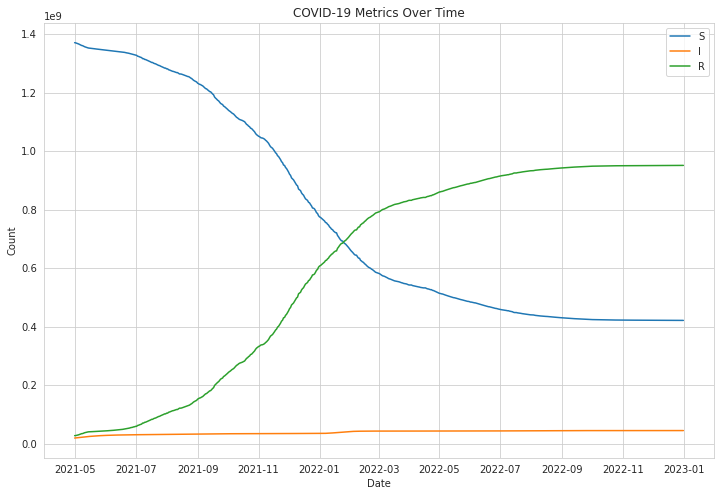

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [4]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    n = len(data)
    return (100 / n) * np.sum(np.abs((data - predictions) / data))

def compute_cost(data, predictions):
    return np.sum(np.square(data - predictions))

def compute_cost(data, predictions):
    return np.abs(data - predictions).mean()

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [5]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [6]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(optimal_beta, optimal_gamma)
print(optimal_beta/optimal_gamma)

0.03925422815833437 0.022659519392619114
1.7323504297765755


In [7]:
ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

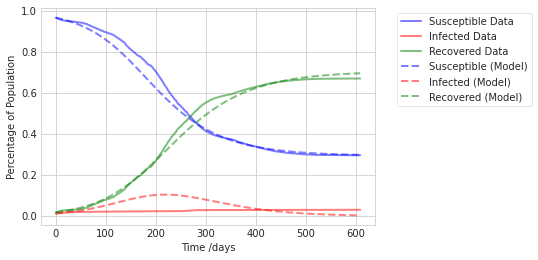

In [8]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [9]:
cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(cost)

99920319.37922898


In [10]:
def deriv_2(y, t, N, beta_array, gamma):
    S, I, R = y
    t = min(int(t), len(beta_array) - 1)
    dSdt = -beta_array[t] * S * I / N
    dIdt = beta_array[t] * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
    
def stringency_dependent_beta(optimal_beta, stringency_weight, stringency_index):
    beta = optimal_beta + (stringency_weight * stringency_index)
    return beta

def objective_function_2(params, y0, t, N, df, gamma, all_stringencies):
    stringency_weight = params[0]
    
    beta_array = stringency_dependent_beta(optimal_beta, stringency_weight, all_stringencies)
    
    predictions = odeint(deriv_2, y0, t, args=(N, beta_array, gamma))
    S, I, R = predictions.T
    
    cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
    return cost

# Set initial values
initial_guess_for_stringency_weight = [0.01]
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)
current_stringency = df['stringency_index'].values

# Perform the optimization
result = minimize(
    objective_function_2,
    initial_guess_for_stringency_weight,
    args=(y0, t, N, df, optimal_gamma, current_stringency),
    method='Nelder-Mead',
)

optimal_stringency_weight = result.x[0]
print(f"Optimal stringency weight: {optimal_stringency_weight}")

Optimal stringency weight: -1.7905485677020872e-07


In [11]:
store_S = []
store_I = []
store_R = []

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

for ith_day in range(0, days_difference + 1):
    t = np.linspace(0, ith_day, ith_day+1)
    stringency_index = df['stringency_index'].iloc[ith_day]
    beta_for_stringency = stringency_dependent_beta(optimal_beta, optimal_stringency_weight, stringency_index)
    predictions = odeint(deriv, y0, t, args=(N, beta_for_stringency, optimal_gamma))
    S, I, R = predictions.T
    store_S.append(S[-1])
    store_I.append(I[-1])
    store_R.append(R[-1])

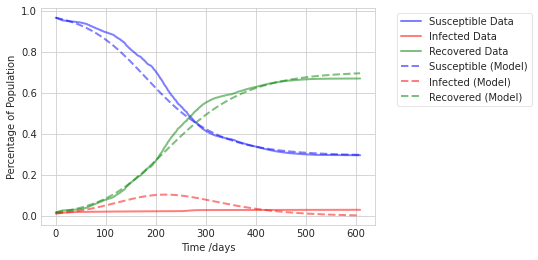

In [12]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, store_S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, store_I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, store_R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_beta_varying_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [13]:
stringency_optimized_cost = compute_cost(df['S'], store_S) + compute_cost(df['I'], store_I) + compute_cost(df['R'], store_R)
print(stringency_optimized_cost)

99898867.66702047


In [14]:
print(cost - stringency_optimized_cost)

21451.712208509445


In [15]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma,
    'optimal_stringency_weight': optimal_stringency_weight
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)